In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data_path = '../data/CALC_STRAIGHT/'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

In [3]:
print('STRAIGHT SEGMENTS:\t'+ str(len(files)))

STRAIGHT SEGMENTS:	232


In [4]:
X = pd.read_csv('../data/PN chuze/PN ataxie.csv',usecols=[0,1])
X.head()

,File,Ts [s]
0,N-01-1-Char00,0.008
1,A-03-1-Char00,0.008
2,N-04-1-Char00,0.008
3,N-06-1-Char00,0.008
4,N-07-1-Char00,0.008


### CALC FILE COLUMNS:
946 columns<br/>
01-X-z    01-V-x    01-V-y    01-V-z    01-Q-s    01-Q-x    01-Q-y  etc...

59 joints, for each joint 16 columns:<br/>
3 World coordinate displacement: X（X、Y、Z）,unit is meter.<br/>
3 World coordinate displacement: V（X、Y、Z）,unit is meter per second.<br/>
4 World coordinate module’s posture data: Q（W、X、Y、Z）.<br/>
3 Module coordinate accelerated speed: A（X、Y、Z），unit is g.<br/>
3 Module coordinate accelerated speed: M（X、Y、Z），unit is radian per second+ 2 columns<br/>
<br/>
2 boolean columns:<br/>
contactL<br/>
contactR<br/>
<br/>
59*16 + 2 = 946
<br/>
Additional in my csv file (not in calc):<br/>
OrigIndex



In [5]:
text_file = open('../data/JointNamesCalc.txt', "r")
joint_names_calc = text_file.read().split('\n')
len(joint_names_calc)

61

In [6]:
corpus_joints = ['Head','Neck','Spine3','Spine2','Spine1','Spine','Hips']
corpus_joints_ind = np.zeros([len(corpus_joints),1])
cc = 0
for c in corpus_joints:
    corpus_joints_ind[cc] = joint_names_calc.index(c)+1
    cc+=1
corpus_joints_ind

array([[16.],
       [17.],
       [18.],
       [19.],
       [20.],
       [21.],
       [ 1.]])

In [7]:
left_foot_ind = joint_names_calc.index('LeftFoot')+1
left_foot_ind

7

In [8]:
right_foot_ind = joint_names_calc.index('RightFoot')+1
right_foot_ind

4

In [9]:
def make_normalized(x):
    xn = (x - min(x))/(max(x)-min(x))
    return xn
    

In [10]:
files = ['N-15-1-Char00part2seg-0.csv','A-03-1-Char00part4seg-0.csv']

N-15-1-Char00part2seg-0.csv
A-03-1-Char00part4seg-0.csv


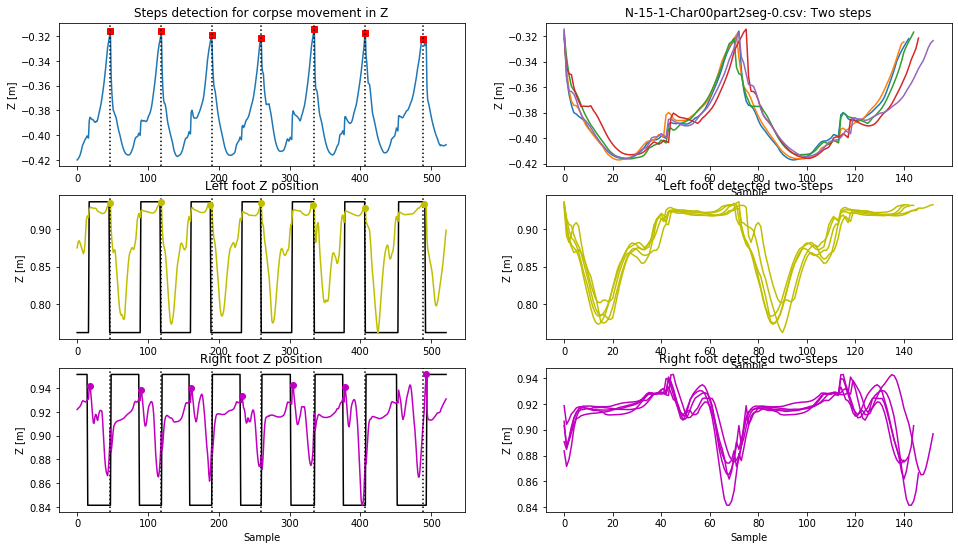

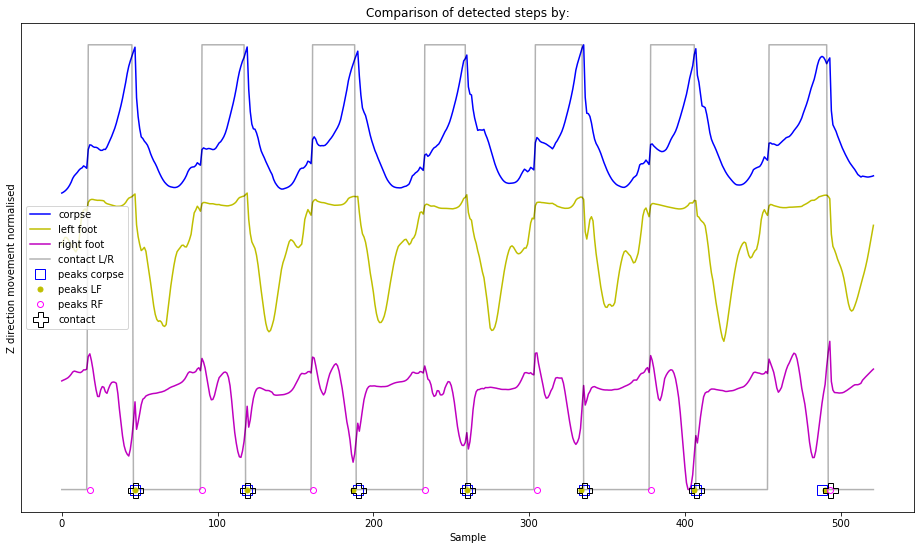

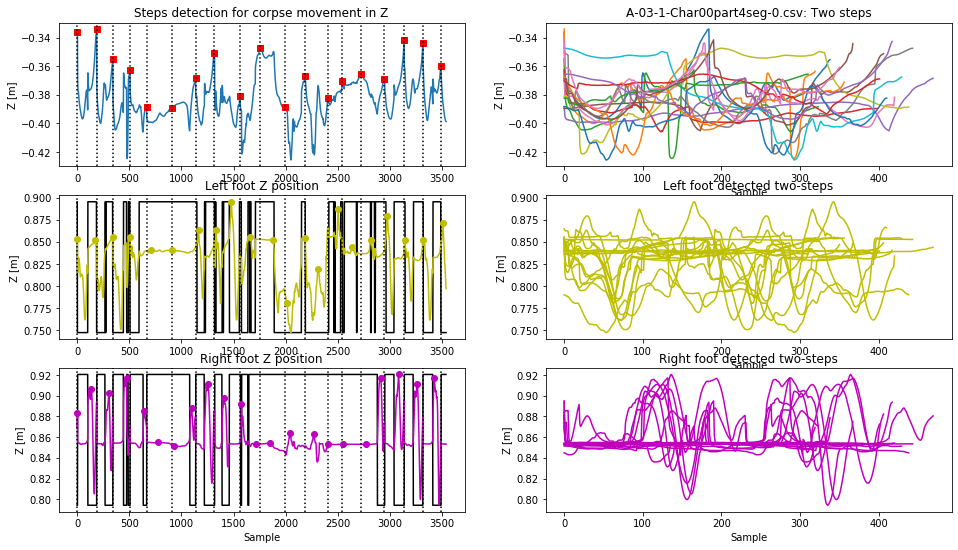

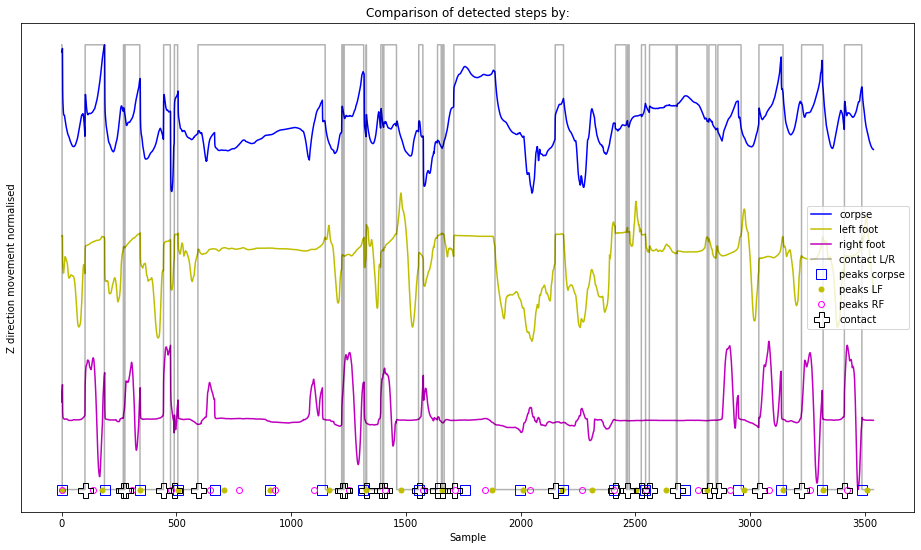

In [11]:
for file in files:
    subject =  file.split(sep='Char00',maxsplit=1)[0]+'Char00'
    print(file)
    
    df = pd.read_csv(data_path + file)
    N = np.size(df,axis=0)
    # Check for the T_sampling from bvh file
    T_sampling = X.loc[X['File'] == subject,'Ts [s]'].values
    # Create time vector for this part
    time = np.linspace(0,N,num=N)*T_sampling
    
    col_list = df.columns.to_list()
    position_cols = [s for s in col_list if "X" in s]
    xdf = df.filter(position_cols,axis=1)
    
    # HEAD
    head_cols = []
    for col in xdf.columns.to_list():
        if (str(int(16))) in col:
            head_cols.append(xdf.columns.to_list().index(col))
    head_df = xdf.filter(xdf.columns[head_cols],axis=1)
    
    # CORPUS
    corpus_cols_ind = []
    for c in corpus_joints_ind:
        for col in xdf.columns.to_list():
                if c<10:
                    name = '0' + str(int(c)) + '-'
                else:
                    name = str(int(c)) + '-'
                if col.startswith(name):
                    corpus_cols_ind.append(xdf.columns.to_list().index(col))

    corpus_df = xdf.filter(xdf.columns[corpus_cols_ind],axis=1)
    
    # LEGS
    leftleg_cols = []
    for col in xdf.columns.to_list():
        if ('0' + str(int(left_foot_ind))) in col:
            leftleg_cols.append(xdf.columns.to_list().index(col))
    rightleg_cols = []
    for col in xdf.columns.to_list():
        if ('0' + str(int(right_foot_ind))) in col:
            rightleg_cols.append(xdf.columns.to_list().index(col))

    foot_L_df = xdf.filter(xdf.columns[leftleg_cols],axis=1)
    foot_R_df = xdf.filter(xdf.columns[rightleg_cols],axis=1)
    
    # Distance threshold for findpeaks = 1 second
    TH_dist = 1 / T_sampling   
    #What to use for steps selection?
    
    #1] CORPUS
    zdim_cols = [s for s in corpus_df.columns.to_list() if "z" in s]
    x = np.zeros([N,1])
    x = corpus_df.filter(zdim_cols,axis=1).mean(axis=1).to_numpy()
    #2] FOOT LEFT/RIGHT
    zdim_cols = [s for s in foot_L_df.columns.to_list() if "z" in s]
    x_LF = np.zeros([N,1])
    x_LF = foot_L_df.filter(zdim_cols,axis=1).mean(axis=1).to_numpy()
    zdim_cols = [s for s in foot_R_df.columns.to_list() if "z" in s]
    x_RF = np.zeros([N,1])
    x_RF = foot_R_df.filter(zdim_cols,axis=1).mean(axis=1).to_numpy()
    
    peaks, _ = find_peaks(x,distance=TH_dist)
    peaksLF, _ = find_peaks(x_LF,distance=TH_dist)
    peaksRF, _ = find_peaks(x_RF,distance=TH_dist)
    
    peaksL = np.where(np.diff(df.contactL)>0)[0]
    peaksR = np.where(np.diff(df.contactR)>0)[0]
    
    if len(peaksL) > len(peaksR):
        steps = peaksL
    else:
        steps = peaksR
    #if len(peaks) > 4:
    #    peaks = peaks[1:-1]
    
    #if len(peaks) > 30:

    fig, ax = plt.subplots(3, 2, figsize=(16,9))
    ax[0,0].plot(x)
    ax[0,0].plot(peaks, x[peaks], "rs")
    #ax[0,0].set_xlabel('Sample')
    ax[0,0].set_ylabel('Z [m]')
    ax[0,0].set_title('Steps detection for corpse movement in Z') 


    #if len(peaks) % 2 == 0:
    #    peaks = peaks[1:]
    for n in range(0,len(peaks)-2):
        tmp_x = x[peaks[n]:peaks[n+2]]
        tmp_LL = foot_L_df.iloc[peaks[n]:peaks[n+2],2].to_numpy()
        tmp_RL = foot_R_df.iloc[peaks[n]:peaks[n+2],2].to_numpy()
        ax[0,1].plot(tmp_x)
        ax[1,1].plot(tmp_LL,'y')
        ax[2,1].plot(tmp_RL,'m')


    ax[0,1].set_xlabel('Sample')
    ax[0,1].set_title(file + ': Two steps')
    ax[0,1].set_ylabel('Z [m]')

    ax[1,0].plot(df.contactL*(max(foot_L_df.iloc[:,2]) - min(foot_L_df.iloc[:,2])) + min(foot_L_df.iloc[:,2]) ,'k')
    ax[2,0].plot(df.contactR*(max(foot_R_df.iloc[:,2]) - min(foot_R_df.iloc[:,2])) + min(foot_R_df.iloc[:,2]) ,'k')
    
    ax[1,0].plot(foot_L_df.iloc[:,2],'y')
    ax[2,0].plot(foot_R_df.iloc[:,2],'m')
    
    

    for xc in peaks:
        ax[0,0].axvline(x=xc, color='k', linestyle=':')
        ax[1,0].axvline(x=xc, color='k', linestyle=':')
        ax[2,0].axvline(x=xc, color='k', linestyle=':')

    #ax[1,0].set_xlabel('Sample')
    ax[1,0].set_title('Left foot Z position')
    ax[1,0].set_ylabel('Z [m]')
    
    ax[2,0].set_xlabel('Sample')
    ax[2,0].set_title('Right foot Z position')
    ax[2,0].set_ylabel('Z [m]')


    ax[1,1].set_xlabel('Sample')
    ax[1,1].set_title('Left foot detected two-steps')
    ax[1,1].set_ylabel('Z [m]')

    ax[2,1].set_xlabel('Sample')
    ax[2,1].set_title('Right foot detected two-steps')
    ax[2,1].set_ylabel('Z [m]')

    ax[1,0].plot(peaksLF, x_LF[peaksLF], "yo")
    ax[2,0].plot(peaksRF, x_RF[peaksRF], "mo")
        #plt.savefig(file[:-4] + '.png')
        #plt.close()
        
    # Comparison of step detection:
    #1] corpse blue
    #2] left foot yellow
    #3] right foot magenta
    #4] contact L/R black/red
    fig = plt.figure(figsize=(16,9))
    plt.plot(make_normalized(x)+2,'b')
    plt.plot(make_normalized(x_LF)+1,'y')
    plt.plot(make_normalized(x_RF),'m')
    plt.plot(df.contactL*3,'k',alpha=0.3)
    #plt.plot(df.contactR*(1),'r')
    plt.plot(peaks, np.zeros(len(peaks)), "s",markersize=10,markerfacecolor="None",
         markeredgecolor='blue')
    plt.plot(peaksLF, np.zeros(len(peaksLF)), "yo",markersize=5)
    plt.plot(peaksRF, np.zeros(len(peaksRF)), "o",markerfacecolor="None",
         markeredgecolor='magenta')
    plt.plot(steps, np.zeros(len(steps)), "P",markerfacecolor="None",
         markeredgecolor='black',markersize=15)
    plt.legend(['corpse','left foot','right foot','contact L/R','peaks corpse','peaks LF','peaks RF','contact'])
    plt.title('Comparison of detected steps by:')
    plt.ylabel('Z direction movement normalised')
    plt.yticks([])
    plt.xlabel('Sample')
    
    #break


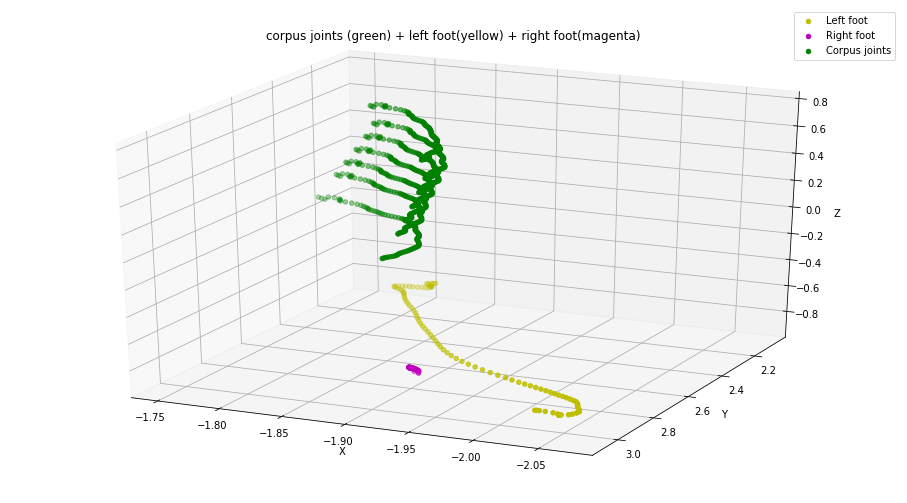

In [12]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')

N = 100

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

xxdf = xdf.iloc[0:N,leftleg_cols]

xdim_cols = [s for s in xxdf if "x" in s]
ydim_cols = [s for s in xxdf if "y" in s]
zdim_cols = [s for s in xxdf if "z" in s]

xs = xxdf.filter(xdim_cols,axis=1).to_numpy()
ys = xxdf.filter(ydim_cols,axis=1).to_numpy()
zs = xxdf.filter(zdim_cols,axis=1).to_numpy()

ax.scatter(xs, ys, -zs, c='y')

xxdf = xdf.iloc[0:N,rightleg_cols]

xdim_cols = [s for s in xxdf if "x" in s]
ydim_cols = [s for s in xxdf if "y" in s]
zdim_cols = [s for s in xxdf if "z" in s]

xs = xxdf.filter(xdim_cols,axis=1).to_numpy()
ys = xxdf.filter(ydim_cols,axis=1).to_numpy()
zs = xxdf.filter(zdim_cols,axis=1).to_numpy()

ax.scatter(xs, ys, -zs, c='m')

xxdf = xdf.iloc[1:N,corpus_cols_ind]

xdim_cols = [s for s in xxdf if "x" in s]
ydim_cols = [s for s in xxdf if "y" in s]
zdim_cols = [s for s in xxdf if "z" in s]

xs = xxdf.filter(xdim_cols,axis=1).to_numpy()
ys = xxdf.filter(ydim_cols,axis=1).to_numpy()
zs = xxdf.filter(zdim_cols,axis=1).to_numpy()

ax.scatter(xs, ys, -zs, c='g')


ax.azim = 115
ax.elev = 25
ax.set_title('corpus joints (green) + left foot(yellow) + right foot(magenta)')
ax.legend(['Left foot','Right foot','Corpus joints'])

plt.show()


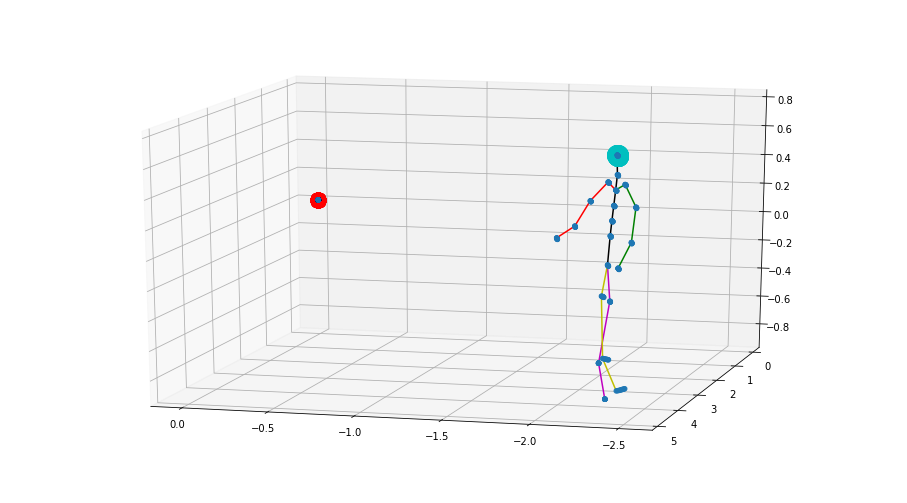

In [13]:
xxdf = xdf.iloc[400:411,:]

xdim_cols = [s for s in xxdf if "x" in s]
ydim_cols = [s for s in xxdf if "y" in s]
zdim_cols = [s for s in xxdf if "z" in s]

xs = xxdf.filter(xdim_cols,axis=1).to_numpy().transpose()
ys = xxdf.filter(ydim_cols,axis=1).to_numpy().transpose()
zs = xxdf.filter(zdim_cols,axis=1).to_numpy().transpose()

fig = plt.figure(figsize=(16,9))
#ax = fig.add_subplot(221)
#ax.plot(xs)
#ax = fig.add_subplot(222)
#ax.plot(ys)
#ax = fig.add_subplot(223)
#ax.plot(zs)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, -zs)
vec = [0,1,2,3]
ax.plot(xs[vec,0], ys[vec,0], -zs[vec,0],'m')
vec = [0,4,5,6]
ax.plot(xs[vec,0], ys[vec,0], -zs[vec,0],'y')
vec = [17,7,8,9,10]
ax.plot(xs[vec,0], ys[vec,0], -zs[vec,0],'g')
vec = [17,11,12,13,14]
ax.plot(xs[vec,0], ys[vec,0], -zs[vec,0],'r')
vec = [15,16,17,18,19,20,0]
ax.plot(xs[vec,0], ys[vec,0], -zs[vec,0],'k')

ax.plot(xs[15], ys[15], -zs[15],'co',markersize=20)

vec = range(21,59)
ax.plot(xs[vec,0], ys[vec,0], -zs[vec,0],'ro',markersize=15)


ax.azim = 105
ax.elev = 15
plt.show()

Index of steps using contact values is simple as this:

In [14]:
steps = np.where(np.diff(df.contactL)>0)[0]
steps

array([ 101,  268,  275,  443,  490,  593, 1220, 1230, 1326, 1390, 1403,
       1555, 1637, 1659, 1708, 2150, 2412, 2466, 2526, 2561, 2682, 2820,
       2859, 3038, 3224, 3411])

In [15]:
len(steps)

26

In [16]:
StepIndex = df.OrigIndex[steps[0]]
StepIndex

55242

You can compare it to previous version:

In [17]:
peaks

array([   3,  187,  342,  507,  666,  906, 1136, 1313, 1557, 1757, 1996,
       2187, 2407, 2544, 2718, 2946, 3136, 3314, 3487])

In [18]:
StepIndex = df.OrigIndex[peaks]
StepIndex

3       55144
187     55328
342     55483
507     55648
666     55807
906     56047
1136    56277
1313    56454
1557    56698
1757    56898
1996    57137
2187    57328
2407    57548
2544    57685
2718    57859
2946    58087
3136    58277
3314    58455
3487    58628
Name: OrigIndex, dtype: int64